In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, ReLU, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from glob import glob
from tensorflow.keras.models import Model

In [2]:
HEIGHT, WIDTH = 512 , 512
batch_size = 8

In [3]:
def read_image(img_path,mask=False):
    img = tf.io.read_file(img_path)
    if mask:
        img = tf.image.decode_png(img, channels=1)
        img.set_shape([None,None,1])
        img = (tf.image.resize(images=img, size=[HEIGHT, WIDTH]))
        img = tf.cast(img, tf.float32)
    else:
        img = tf.image.decode_png(img, channels=3)
        img.set_shape([None,None,3])
        img = (tf.image.resize(images=img, size=[HEIGHT, WIDTH]))
        img = tf.cast(img,tf.float32) / 255.0
    return img
      

In [4]:
def load_image(images,masks):
    image = read_image(images,mask=False)
    mask = read_image(masks,mask=True)
    return image, mask

In [5]:
def customDataGenerator(images,masks):
    dataset = tf.data.Dataset.from_tensor_slices((images,masks))
    dataset = dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [8]:
dataset_path = '/kaggle/input/instance-level-human-parsing/instance-level_human_parsing'

In [10]:
train_images_folder = sorted(glob(dataset_path+'/Training/Images/*'))
train_mask_folder = sorted(glob(dataset_path+'/Training/Category_ids/*'))
valid_images_folder = sorted(glob(dataset_path+'/Validation/Images/*'))
valid_mask_folder = sorted(glob(dataset_path+'/Validation/Category_ids/*'))

train_dataset = customDataGenerator(train_images_folder, train_mask_folder)
valid_dataset = customDataGenerator(valid_images_folder, valid_mask_folder)

In [11]:
def conv2DBlock(input_layer,filters=256, kernel_size=1, dilation_rate=1,name=None,use_bias=True,activation=None):
    layer = Conv2D(filters=filters,kernel_size=kernel_size, dilation_rate=dilation_rate,padding='same',kernel_initializer='he_normal',activation=activation,use_bias=use_bias,name=name)(input_layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)
    return layer


### Atrous Spatial Pyramid Pooling (ASPP) Module
![ASPP](Images/Atrous-Spatial-Pyramid-Pooling-Module-ASPP.PNG)

In [12]:
#The Atrious Spatial Pyramid Pooling Block

def ASPP_Block(input_layer):
    dims = tf.keras.backend.int_shape(input_layer)
    
    layer = AveragePooling2D(pool_size=(dims[-3],dims[-2]))(input_layer)
    layer = conv2DBlock(layer,filters=256)
    output_pooling = UpSampling2D(size=(dims[-3] // layer.shape[1], dims[-2] // layer.shape[2]),
                                  interpolation='bilinear')(layer)


    output_1x1 = conv2DBlock(input_layer,filters=256,use_bias=False,name='ASPP_1x1conv')

    output_3x3_d6 = conv2DBlock(input_layer,filters=256,kernel_size=3,dilation_rate=6, use_bias=False,name='ASPP_3x3conv_d6')
    
    output_3x3_d12 = conv2DBlock(input_layer,filters=256,kernel_size=3,dilation_rate=12, use_bias=False,name='ASPP_3x3conv_d12')

    output_3x3_d18 = conv2DBlock(input_layer,filters=256,kernel_size=3,dilation_rate=18, use_bias=False,name='ASPP_3x3conv_d18')


    output = Concatenate(name='ASPP_Concatenate')([output_1x1,output_3x3_d6,output_3x3_d12,
                           output_3x3_d18,output_pooling]) #Default Concatenate axis is -1(last shape, shape[-1]). It denotes the channels/filters axis. Height x Width x Channels

    block_output = conv2DBlock(output,filters=256,kernel_size=1,use_bias=False,name='ASPP_Final1x1')

    return block_output



### DeepLabV3Plus Architecture
![DeepLabV3Plus](Images/DeepLabV3Plus.PNG)

In [13]:
def DeepLabV3Plus(num_classes=20):
    model_input = Input(shape=(HEIGHT,WIDTH,3))
    resnet50_model = ResNet50(include_top=False,weights='imagenet',input_tensor=model_input)

    #Encoder
    backbone_layer_encoder = resnet50_model.get_layer('conv4_block6_2_relu').output
    encoder_output = ASPP_Block(backbone_layer_encoder)


    #Decoder
    backbone_layer_decoder = resnet50_model.get_layer('conv2_block3_2_relu').output
    decoder_input_a = conv2DBlock(backbone_layer_decoder,filters=48,kernel_size=1,use_bias=False,name='decoder_1x1conv')

    decoder_input_b = UpSampling2D(size=(HEIGHT // 4 // encoder_output.shape[1],
                                         WIDTH // 4 // encoder_output.shape[2]),
                                   interpolation='bilinear',name='encoder_to_decoder_UpSampling')(encoder_output)

    decoder = Concatenate(name='decoder_concat')([decoder_input_a,decoder_input_b])

    decoder = conv2DBlock(decoder,filters=256,kernel_size=3,activation='relu',use_bias=False)
    decoder = conv2DBlock(decoder,filters=256,kernel_size=3,activation='relu',use_bias=False)

    decoder = UpSampling2D(size=(HEIGHT // decoder.shape[1], WIDTH // decoder.shape[2]),
                           interpolation='bilinear')(decoder)

    model_output = Conv2D(num_classes,kernel_size=1,padding='same')(decoder)
    return Model(inputs = model_input, outputs = model_output, name='DeepLabV3Plus')




In [14]:
model = DeepLabV3Plus()
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
print(model.summary())

94773248/94765736 [==============================] - 2s 0us/step
Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
_____________________

In [15]:
epochs = 20 #3+2 epochs done
step_per_epoch = len(train_images_folder) // batch_size
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
filepath = 'DeepLabV3Plus_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='loss',
                                                save_best_only=True,
                                                mode='min',
                                               verbose=True)

In [ ]:



model.fit(train_dataset,steps_per_epoch=step_per_epoch,epochs=epochs,
          validation_data=valid_dataset,
          validation_steps=len(valid_images_folder)//batch_size,
          callbacks=[checkpoint])

In [16]:
model.load_weights('/kaggle/input/saved-models/DeepLabV3Plus_model1.h5')
model.fit(train_dataset,steps_per_epoch=step_per_epoch,epochs=epochs,
          validation_data=valid_dataset,
          validation_steps=len(valid_images_folder)//batch_size,
          callbacks=[checkpoint])

Epoch 1/20
3535/3535 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8849
Epoch 00001: loss improved from inf to 0.36008, saving model to DeepLabV3Plus_model.h5
3535/3535 [==============================] - 1660s 470ms/step - loss: 0.3601 - accuracy: 0.8849 - val_loss: 0.5914 - val_accuracy: 0.8299
Epoch 2/20
3535/3535 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.8907
Epoch 00002: loss improved from 0.36008 to 0.34229, saving model to DeepLabV3Plus_model.h5
3535/3535 [==============================] - 1643s 465ms/step - loss: 0.3423 - accuracy: 0.8907 - val_loss: 0.5441 - val_accuracy: 0.8392
Epoch 3/20
3535/3535 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8959
Epoch 00003: loss improved from 0.34229 to 0.32715, saving model to DeepLabV3Plus_model.h5
3535/3535 [==============================] - 1644s 465ms/step - loss: 0.3272 - accuracy: 0.8959 - val_loss: 0.5456 - val_accuracy: 0.8383
Epoch 4/20
3535/3535 [=

KeyboardInterrupt: 

## Labels List
![Class Defintions](Images/Class_Definitions.PNG)

### We can use this model for various other tasks. Some of them are executed below : 

# Human Segmentation

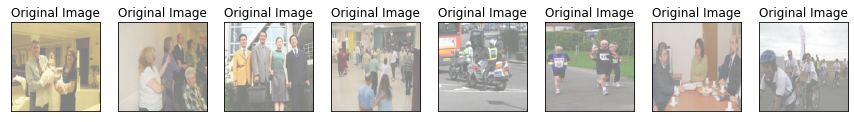

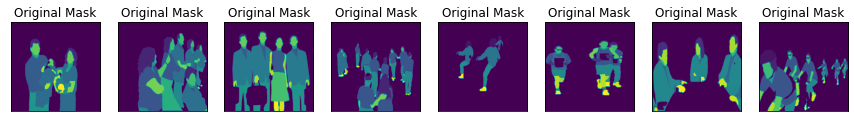

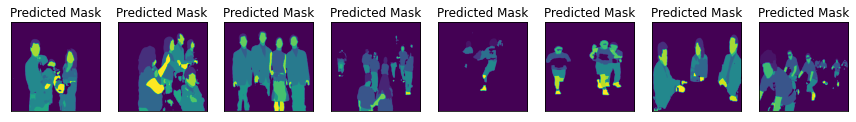

In [24]:
#model.load_weights('/content/drive/My Drive/deeplab_model 19.h5')

def inference(dataset):
    plt.figure(figsize=(15,15))
    for i in range(batch_size):
        for val in dataset.take(1):
            img = tf.cast((val[0][i]+1)*127.5,tf.uint8)
            plt.subplot(1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img)
            plt.title("Original Image")
    plt.show()
    
    
    plt.figure(figsize=(15,15))
    for i in range(batch_size):
        for val in dataset.take(1):
            plt.subplot(1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(tf.squeeze(val[1][i]))
            plt.title("Original Mask")
    plt.show()
    
    plt.figure(figsize=(15,15))
    for i in range(batch_size):
        for val in dataset.take(1):
            img = val[0][i]
            plt.subplot(1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            predsTrain = model.predict(np.expand_dims((img),axis=0))
            out=np.squeeze(predsTrain)
            y = np.argmax(out, axis=2)
            plt.imshow(y)
            plt.title("Predicted Mask")
    
    plt.show()

inference(valid_dataset)

# Clothes Extractor

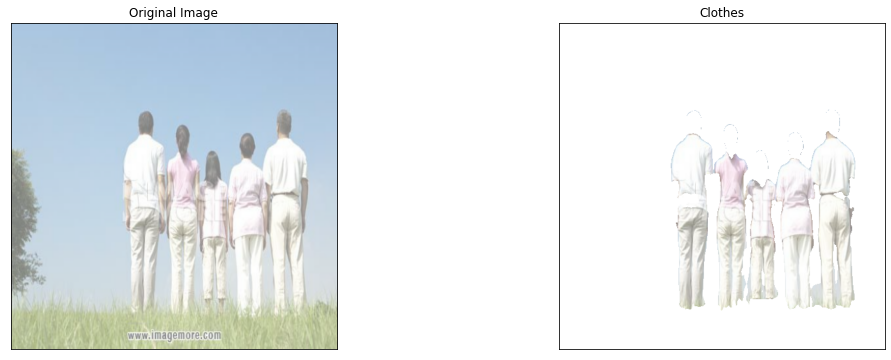

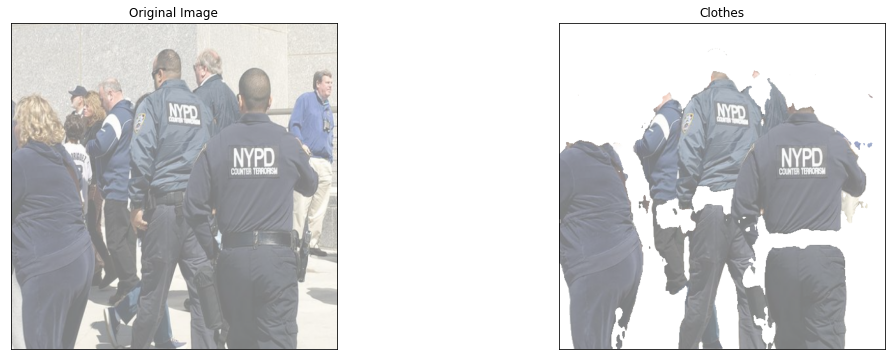

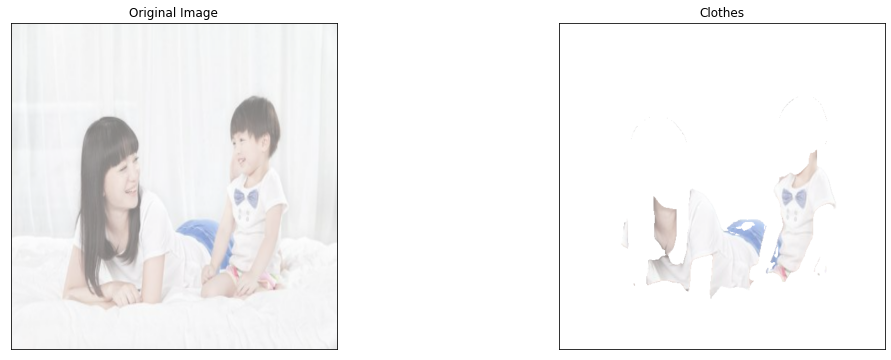

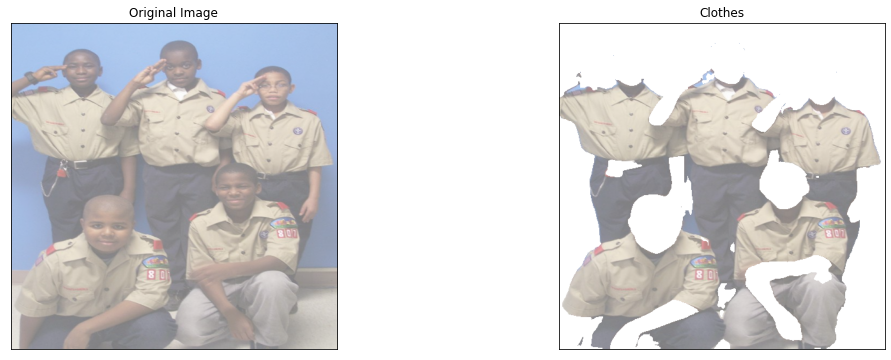

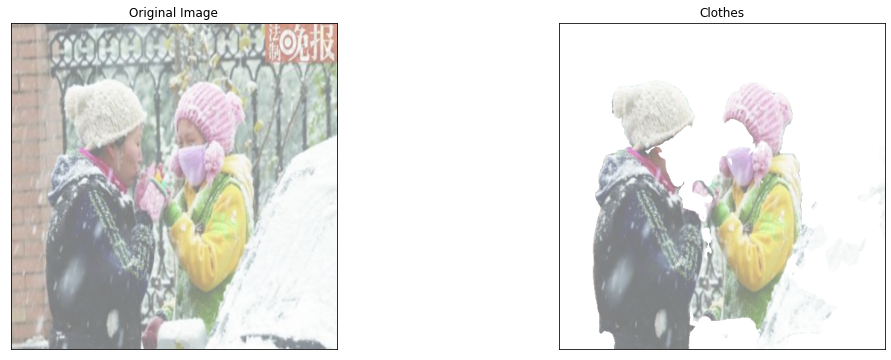

In [32]:
clothes_class = [1,3,5,6,7,8,9,10,11,12]
background_class = set(range(20)) - set(clothes_class)

for i in np.random.randint(0, len(valid_images_folder), 5):
    plt.subplots(1, 3, figsize=(18, 6))

    image = read_image(valid_images_folder[i]).numpy()
    gt_mask = read_image(valid_mask_folder[i], mask=True).numpy()

    mask = np.argmax(model.predict(image[None, ...])[0], axis=-1)
    display_image = np.uint8((image.copy() + 1 ) * 127.5)

    clothes = display_image.copy()
    for bg_id in background_class:
        clothes[mask == bg_id] = 255

    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.imshow(display_image)

    plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Clothes')
    plt.imshow(clothes)